# [모듈 3.4] 세이지메이커 모델 스텝 개발 (SageMaker Model Building Pipeline 훈련 스텝)

이 노트북은 아래와 같은 목차로 진행 됩니다. 전체를 모두 실행시에 완료 시간은 약 5분-10분 소요 됩니다.

- 0. 세이지메이커 모델 개요 
- 1. 모델 빌딩 파이프라인에서 세이지 메이커 모델 생성 스텝 실행 
    
---
### 노트북 커널
- 이 워크샵은 노트북 커널이 `conda_python3` 를 사용합니다. 다른 커널일 경우 변경 해주세요.
---


# 1.세이지메이커 모델 개요

## 1.1. 세이지 메이커 훈련, 배포, 추론 아키텍쳐
아래 그림에서 "Deployment / hosting on ML compute instances" 와 "Endpoint", 세이지 메이커 모델 를 보여 주고 있습니다.
- 상세 사항은 여기를 참조 하세요. --> [Amazon SageMaker 에서 모델 배포](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/how-it-works-deployment.html)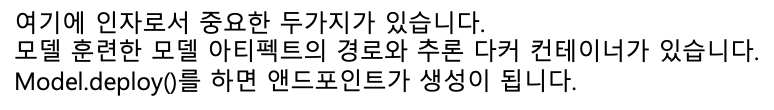

![sagemaker_architecture.png](img/sagemaker-architecture.png)



## 1.2 세이지 메이커 모델 스텝 
- Create Model 단계의 개발자 가이드 
    - [Create Model 스텝](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/build-and-manage-steps.html#step-type-create-model)



# 2. 기본 라이브러리 로딩

세이지 메이커 관련 라이브러리를 로딩 합니다.

기본적인 세이지 메이커 정보를 가져옵니다.

In [1]:
import boto3
import sagemaker
import pandas as pd

sagemaker_session = sagemaker.session.Session()
role = sagemaker.get_execution_role()

%store -r 

# 3. 모델 빌딩 파이프라인 의 스텝(Step) 생성



## 3.1 모델 빌딩 파이프라인 변수 생성

이 단계에서는 파이프라인 변수를 사용하지 않습니다.


## 3.2 배포에 사용할 세이지 메이커 모델 정의 

실시간 엔드포인트를 생성 하기 위해 SageMaker Model을 생성합니다.

```python
model = Model(
    image_uri= step_train.properties.AlgorithmSpecification.TrainingImage,
    model_data= step_train.properties.ModelArtifacts.S3ModelArtifacts,
    sagemaker_session=sagemaker_session,
    role=role,
)
```

구체적으로, `TrainingStep` 인스턴스인 `step_train`의 속성 중 `TrainingImagea, S3ModelArtifacts` 의 결과물을 입력으로 다시 사용합니다.
- 아래의 예시는 '세이지 메이커 모델 생성' 스텝을 독립적으로 실행하기 위해서, 이전 노트북의 결과인 image_uri (모델 훈련시 다커 컨테이너 경로), model_data 또한 이전 노트북에서 모델 훈련의 아티펙트의 경로인 train_model_artifact를 사용합니다.
- [알림] image_uri 를 여기서는 모델 훈련시의 다커 컨테이너와 동일하게 추론에서 사용했습니다. 추론 다커 컨테이너를 따로 구성해서 사용할 수도 있습니다.
- [알림] `TrainingStep`의 `properties` 속성은 [DescribeTrainingJob](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_DescribeTrainingJob.html) API의 응답결과와 동일합니다.


In [2]:
from sagemaker.model import Model

model = Model(
    image_uri=image_uri,
    model_data= train_model_artifact,
    sagemaker_session=sagemaker_session,
    role=role,
)

## 3.3 세이지 메이커 모델 생성 스탭 생성

In [3]:
from sagemaker.inputs import CreateModelInput
from sagemaker.workflow.steps import CreateModelStep


inputs = CreateModelInput(
    instance_type="ml.m5.large",
)
step_create_model = CreateModelStep(
    name="Fraud-Basic-CreateModel",
    model=model,
    inputs=inputs,
)

# 4. 파리마터, 단계, 조건을 조합하여 최종 파이프라인 정의 및 실행



## 4.1 파이프라인 정의


In [4]:
from sagemaker.workflow.pipeline import Pipeline

pipeline_name = project_prefix
pipeline = Pipeline(
    name=pipeline_name,
    steps=[step_create_model],
)

## 4.2 파이프라인 정의 확인
위에서 정의한 파이프라인 정의는 Json 형식으로 정의 되어 있습니다.

In [5]:
import json


definition = json.loads(pipeline.definition())
definition

{'Version': '2020-12-01',
 'Metadata': {},
 'Parameters': [],
 'PipelineExperimentConfig': {'ExperimentName': {'Get': 'Execution.PipelineName'},
  'TrialName': {'Get': 'Execution.PipelineExecutionId'}},
 'Steps': [{'Name': 'Fraud-Basic-CreateModel',
   'Type': 'Model',
   'Arguments': {'ExecutionRoleArn': 'arn:aws:iam::051065130547:role/sagemaker-notebook-SageMakerIamRole-13SLYUPDCYIY9',
    'PrimaryContainer': {'Image': '683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.3-1',
     'Environment': {},
     'ModelDataUrl': 's3://sagemaker-us-east-1-051065130547/sagemaker-webinar-pipeline-base/training_jobs/pipelines-4o0prgdpt7zv-Fraud-Basic-Train-8qHPipk1OF/output/model.tar.gz'}}}]}

## 4.3 파이프라인 정의를 제출하고 실행하기 

파이프라인 정의를 파이프라인 서비스에 제출합니다. 함께 전달되는 역할(role)을 이용하여 AWS에서 파이프라인을 생성하고 작업의 각 단계를 실행할 것입니다.   

In [6]:
pipeline.upsert(role_arn=role)
execution = pipeline.start()

In [7]:
execution.describe()

{'PipelineArn': 'arn:aws:sagemaker:us-east-1:051065130547:pipeline/sagemaker-webinar-pipeline-base',
 'PipelineExecutionArn': 'arn:aws:sagemaker:us-east-1:051065130547:pipeline/sagemaker-webinar-pipeline-base/execution/qbzra1i5h344',
 'PipelineExecutionDisplayName': 'execution-1647853935893',
 'PipelineExecutionStatus': 'Executing',
 'CreationTime': datetime.datetime(2022, 3, 21, 9, 12, 15, 768000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2022, 3, 21, 9, 12, 15, 768000, tzinfo=tzlocal()),
 'CreatedBy': {},
 'LastModifiedBy': {},
 'ResponseMetadata': {'RequestId': '3b9b274c-5a66-44fd-b457-b94f51b586ec',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '3b9b274c-5a66-44fd-b457-b94f51b586ec',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '427',
   'date': 'Mon, 21 Mar 2022 09:12:15 GMT'},
  'RetryAttempts': 0}}

## 4.4 파이프라인 실행 기다리기

In [8]:
execution.wait()

## 4.5 파이프라인 실행 단계 기록 보기

In [9]:
execution.list_steps()

[{'StepName': 'Fraud-Basic-CreateModel',
  'StartTime': datetime.datetime(2022, 3, 21, 9, 12, 17, 481000, tzinfo=tzlocal()),
  'EndTime': datetime.datetime(2022, 3, 21, 9, 12, 18, 691000, tzinfo=tzlocal()),
  'StepStatus': 'Succeeded',
  'AttemptCount': 0,
  'Metadata': {'Model': {'Arn': 'arn:aws:sagemaker:us-east-1:051065130547:model/pipelines-qbzra1i5h344-fraud-basic-createmo-huw6k8f1ay'}}}]

# 5. 세이지 메이커 스튜디오에서 확인하기
- 아래의 그림 처럼 SageMaker Studio에 로긴후에 따라하시면, SageMaker Studio 에서도 실행 내역을 확인할 수 있습니다.
    - SageMaker Studio 개발자 가이드 --> [SageMaker Studio](https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/studio.html)



![create_model_sm.png](img/create_model_sm.png)

# 7. 모델 아티펙트 경로 추출


### 세이지 메이커 모델의 경로를 저장함. 
- 다음 노트북에서 사용합니다.

In [10]:
response = execution.list_steps()
sagemaker_model = response[0]['Metadata']['Model']['Arn'].split("/")[-1]
print("sagemaker_model: \n", sagemaker_model)

%store sagemaker_model

sagemaker_model: 
 pipelines-qbzra1i5h344-fraud-basic-createmo-huw6k8f1ay
Stored 'sagemaker_model' (str)
